In [4]:
library(ggplot2)
library(gridExtra)
library(scales)
library(comprehenr)
library(dplyr)
library(stringr)
library(pracma)
library(reshape2)

# Exercise 1
The number of particles emitted by a radioactive source during a fixed interval of time $(\Delta t= 10 s )$ follows a Poisson distribution on the parameter $\mu$. The number of particles observed during
consecutive time intervals is: 4, 1, 3, 1 and 3:

(a) suppose a uniform prior distribution for the parameter µ
- determine and draw the posterior distribution for µ, given the data
- evaluate mean, median and variance, both analytically and numerically in R

(b) suppose a Jeffrey’s prior for the parameter µ
- determine and draw the posterior distribution for µ, given the data
- evaluate mean, median and variance, both analytically and numerically in R

(c) evaluate a 95% credibility interval for the results obtained with both priors. Compare the result
with that obtained using a normal approximation for the posterior distribution, with the same mean
and standard deviation


-> _Solution_

For a single measurement the likelihood follows a Poisson process, taking multipl independent measurements we can look at the likelihood as a Gamma distribution:
$$
\text{Gamma}(\mu|\alpha, \lambda) = \frac{\lambda^{\alpha}}{\Gamma(\alpha)} \mu^{\alpha-1}e^{-\lambda \mu}
$$
with $\alpha = \sum x_j +1$, $\lambda = n$, $x_i$ are the observations and $\mu$ is the $\mu$ parameter of the Poisson process.

The uniform prior is well known, the Jeffrey's prior is $\propto 1/\sqrt{\mu}$. So, knowing that the Gamma distribution is the conjugate family for the inference of $\mu$ from a Poisson process we can rethink at our prior as Gamma distributions $\text{Gamma}(\mu|\alpha, \lambda)$:
- $\text{unif}(\mu) = \text{Gamma}(\mu|1, 0)$
- $\text{jeff}(\mu)  = \text{Gamma}(\mu|1/2, 0)$

So the expected value and variance of the posterior can be computed analytically as:
- $E[\mu|{x_i}] = \frac{\alpha'}{\lambda'} $
- $\text{var}[\mu|{x_i}] =  \frac{\alpha'}{\lambda'^2}$

with $\alpha' = \alpha + \sum x_i$, $\lambda' = \lambda + n$.

In [3]:
observations = c(4, 1, 3, 1, 3)

n_points     = 10000
max_mu       = 10
mu           = seq(0.1, max_mu, length.out=n_points)
pois_like    = dgamma(x=mu, sum(observations)+1, length(observations))

# a) posterior w uniform prior
unif_prior_      = rep(1, n_points)
unif_prior       = unif_prior_/sum(unif_prior_*max_mu/n_points)
unif_posterior_  = pois_like*unif_prior
unif_posterior   = unif_posterior_/sum(unif_posterior_*max_mu/n_points)
## evaluate mean median and variance (analytically and numerically (_n)) -> median only numerically
unif_mean       = (1+ sum(observations))/length(observations)
unif_variance   = (1+ sum(observations))/length(observations)^2
unif_mean_n     = sum(unif_posterior*mu*max_mu/n_points)
unif_median_n   = mu[cumsum(unif_posterior*max_mu/n_points)>=0.5][1]
unif_variance_n = sum(unif_posterior*mu^2*max_mu/n_points) - unif_mean_n^2

# b) posterior w Jeffery's prior
jeff_prior_      = to_vec(for(mu_i in mu) 1/sqrt(mu_i))
jeff_prior       = jeff_prior_/sum(jeff_prior_*max_mu/n_points)
jeff_posterior_  = pois_like*jeff_prior
jeff_posterior   = jeff_posterior_/sum(jeff_posterior_*max_mu/n_points)
## evaluate mean median and variance (analytically and numerically (_n)) -> median only numerically
jeff_mean       = (1/2+ sum(observations))/length(observations)
jeff_variance   = (1/2+ sum(observations))/length(observations)^2
jeff_mean_n     = sum(jeff_posterior*mu*max_mu/n_points)
jeff_median_n   = mu[cumsum(jeff_posterior*max_mu/n_points)>=0.5][1]
jeff_variance_n = sum(jeff_posterior*mu^2*max_mu/n_points) - jeff_mean_n^2

# c) 95% credibility interval
unif_low  = mu[cumsum(unif_posterior*max_mu/n_points)>0.025][1]
unif_high = mu[cumsum(unif_posterior*max_mu/n_points)>0.975][1]
jeff_low  = mu[cumsum(jeff_posterior*max_mu/n_points)>0.025][1]
jeff_high = mu[cumsum(jeff_posterior*max_mu/n_points)>0.975][1]
## compare the result with that obtained using a normal approximation for the posterior distribution, with the same mean and standard deviation
unif_gauss     = dnorm(mu, unif_mean, sqrt(unif_variance))
unif_gauss_high = unif_mean + 2*sqrt(unif_variance)
unif_gauss_low  = unif_mean - 2*sqrt(unif_variance)
jeff_gauss     = dnorm(mu, jeff_mean, sqrt(jeff_variance))
jeff_gauss_high = jeff_mean + 2*sqrt(jeff_variance)
jeff_gauss_low  = jeff_mean - 2*sqrt(jeff_variance)

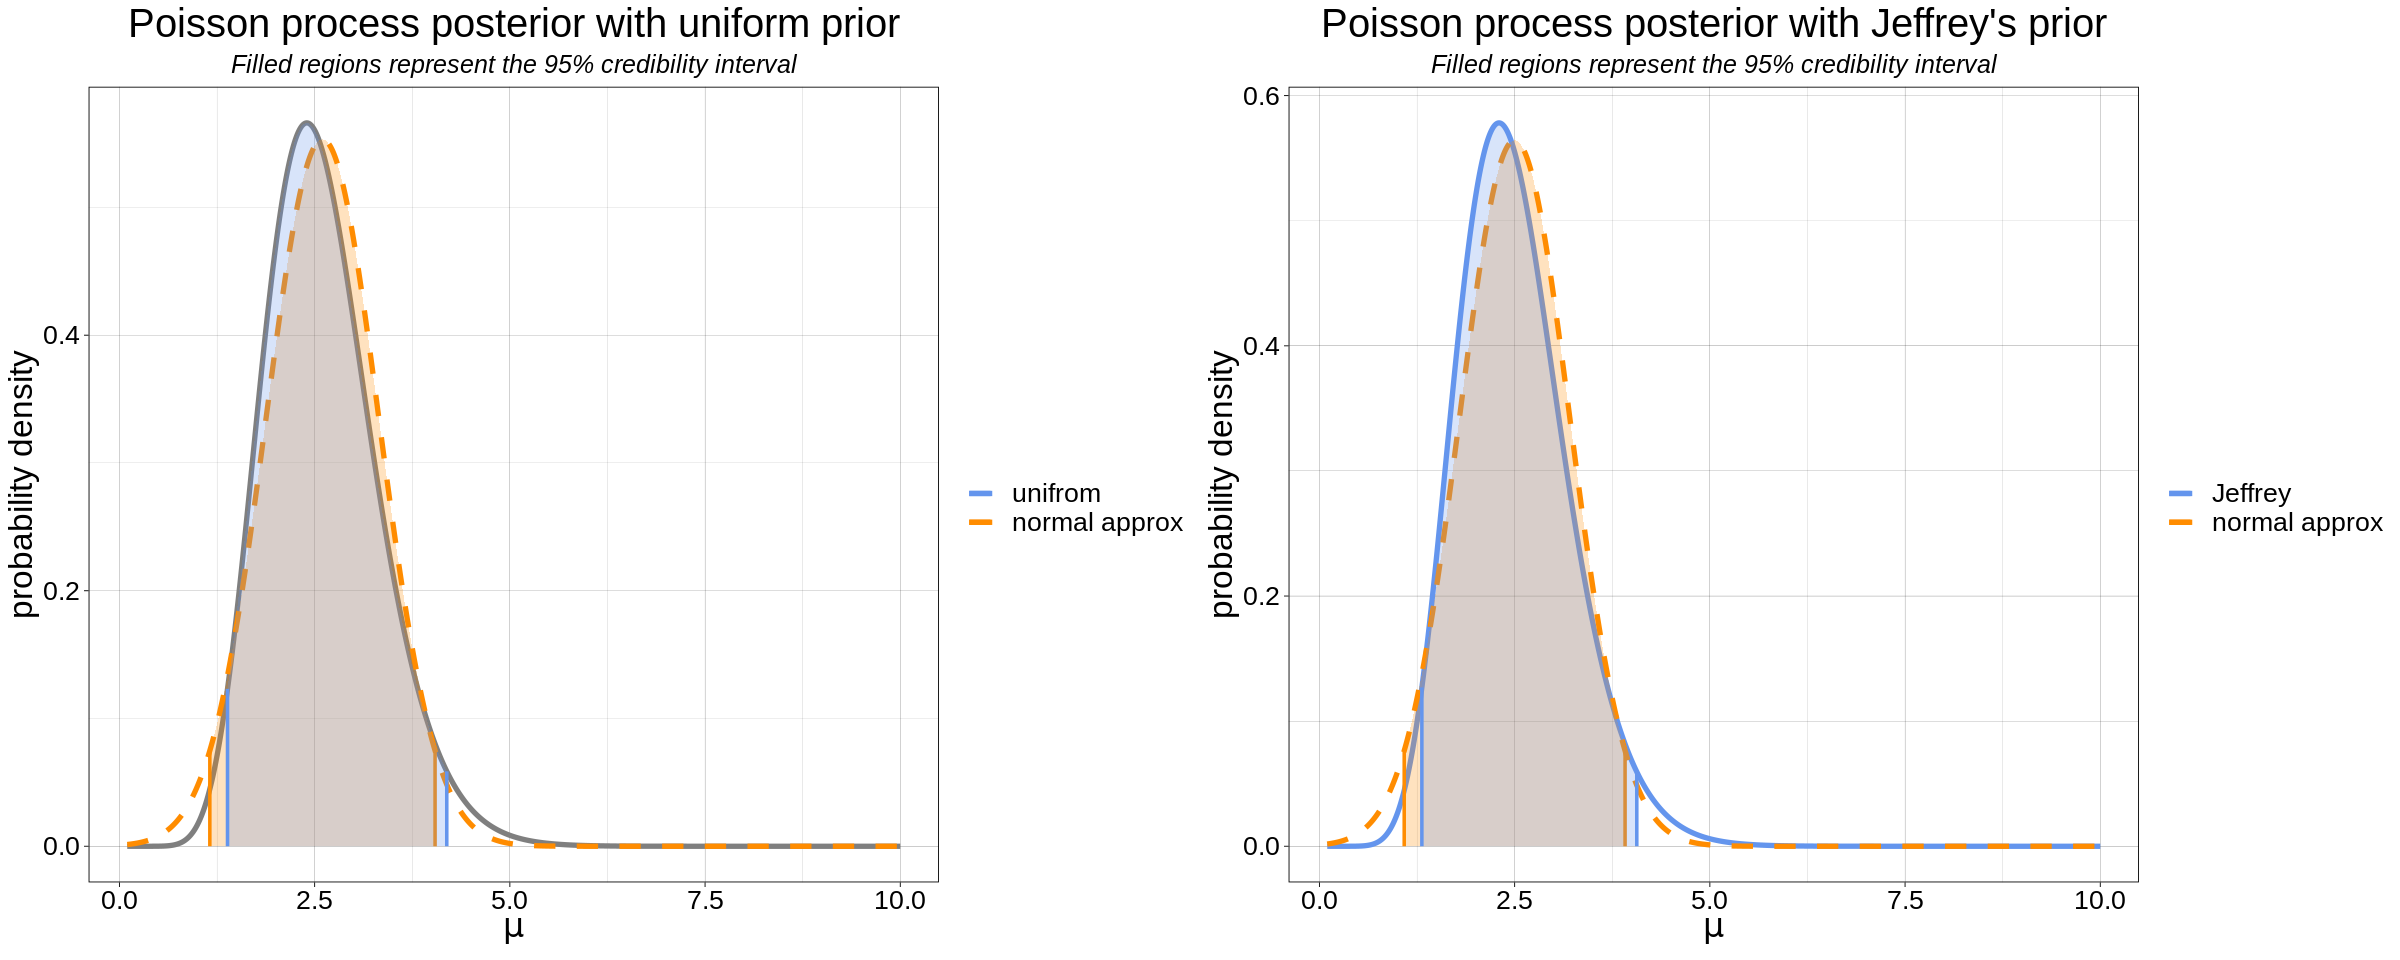

In [88]:
options(repr.plot.width=20, repr.plot.height=8) 
cols = c("unifrom"="cornflowerblue", "normal approx"="darkorange")
plot_unif_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=mu, y=unif_posterior, color="uniform"), lwd=1.5) + 
     geom_line(aes(x=mu, y=unif_gauss, color="normal approx"), lwd=1.5, linetype="dashed") + 
     geom_ribbon(aes(x=mu[which(between(mu, unif_gauss_low, unif_gauss_high))], 
                     ymax=unif_gauss[which(between(mu, unif_gauss_low, unif_gauss_high))], 
                     ymin=rep(0, n_points)[which(between(mu, unif_gauss_low, unif_gauss_high))]),
                 fill="darkorange",
                 alpha=0.25) +  
     geom_segment(aes(x=unif_gauss_high, xend=unif_gauss_high, y=0, yend=unif_gauss[which(mu>=unif_gauss_high)][1]),
                  color="darkorange",
                  lwd=1) +
     geom_segment(aes(x=unif_gauss_low, xend=unif_gauss_low, y=0, yend=unif_gauss[which(mu>=unif_gauss_low)][1]),
                  color="darkorange",
                  lwd=1) +    
     geom_ribbon(aes(x=mu[which(between(mu, unif_low, unif_high))], 
                     ymax=unif_posterior[which(between(mu, unif_low, unif_high))], 
                     ymin=rep(0, n_points)[which(between(mu, unif_low, unif_high))]),
                 fill="cornflowerblue",
                 alpha=0.25) +      
     geom_segment(aes(x=unif_high, xend=unif_high, y=0, yend=unif_posterior[which(mu==unif_high)]),
                  color="cornflowerblue",
                  lwd=1) +
     geom_segment(aes(x=unif_low, xend=unif_low, y=0, yend=unif_posterior[which(mu==unif_low)]),
                  color="cornflowerblue",
                  lwd=1) +                                                
     theme(text = element_text(size=20)) +
     ggtitle("Poisson process posterior with uniform prior") +
     labs(subtitle="Filled regions represent the 95% credibility interval") +
     theme(plot.title = element_text(hjust = 0.5), 
           plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
     ylab("probability density") +
     xlab(expression(mu)) +
     scale_color_manual(name="",
                        values=cols)

cols = c("Jeffrey"="cornflowerblue", "normal approx"="darkorange")
plot_jeff_posterior <- ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=mu, y=jeff_posterior, color="Jeffrey"), lwd=1.5) + 
     geom_line(aes(x=mu, y=jeff_gauss, color="normal approx"), lwd=1.5, linetype="dashed") + 
     geom_ribbon(aes(x=mu[which(between(mu, jeff_gauss_low, jeff_gauss_high))], 
                     ymax=jeff_gauss[which(between(mu, jeff_gauss_low, jeff_gauss_high))], 
                     ymin=rep(0, n_points)[which(between(mu, jeff_gauss_low, jeff_gauss_high))]),
                 fill="darkorange",
                 alpha=0.25) +  
     geom_segment(aes(x=jeff_gauss_high, xend=jeff_gauss_high, y=0, yend=jeff_gauss[which(mu>=jeff_gauss_high)][1]),
                  color="darkorange",
                  lwd=1) +
     geom_segment(aes(x=jeff_gauss_low, xend=jeff_gauss_low, y=0, yend=jeff_gauss[which(mu>=jeff_gauss_low)][1]),
                  color="darkorange",
                  lwd=1) +    
     geom_ribbon(aes(x=mu[which(between(mu, jeff_low, jeff_high))], 
                     ymax=jeff_posterior[which(between(mu, jeff_low, jeff_high))], 
                     ymin=rep(0, n_points)[which(between(mu, jeff_low, jeff_high))]),
                 fill="cornflowerblue",
                 alpha=0.25) +      
     geom_segment(aes(x=jeff_high, xend=jeff_high, y=0, yend=jeff_posterior[which(mu==jeff_high)]),
                  color="cornflowerblue",
                  lwd=1) +
     geom_segment(aes(x=jeff_low, xend=jeff_low, y=0, yend=jeff_posterior[which(mu==jeff_low)]),
                  color="cornflowerblue",
                  lwd=1) +                                                
     theme(text = element_text(size=20)) +
     ggtitle("Poisson process posterior with Jeffrey's prior") +
     labs(subtitle="Filled regions represent the 95% credibility interval") +
     theme(plot.title = element_text(hjust = 0.5), 
           plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
     ylab("probability density") +
     xlab(expression(mu)) +
     scale_color_manual(name="",
                        values=cols)

grid.arrange(plot_unif_posterior, plot_jeff_posterior, ncol=2)

In [4]:
cat("###################################### Uniform prior ######################################")
cat("\n Analytically:\n")
cat("\t mean:", unif_mean, "variance:", unif_variance)
cat("\n Numerically:\n")
cat("\t mean:", unif_mean_n, "variance:", unif_variance_n, "median:", unif_median_n)
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", unif_low, "high:", unif_high,"with the uniform prior \n")
cat("\t low:", unif_gauss_low, "high:", unif_gauss_high,"with the normal approximation of the posterior \n\n")
cat("###################################### Jeffrey's prior ######################################")
cat("\n Analytically:\n")
cat("\t mean:", jeff_mean, "variance:", jeff_variance)
cat("\n Numerically:\n")
cat("\t mean:", jeff_mean_n, "variance:", jeff_variance_n, "median:", jeff_median_n)
cat("\n Bounds for a 95% credibility interval:\n")
cat("\t low:", jeff_low, "high:", jeff_high,"with the Jeffrey's prior \n")
cat("\t low:", jeff_gauss_low, "high:", jeff_gauss_high,"with the normal approximation of the posterior \n")

###################################### Uniform prior ######################################
 Analytically:
	 mean: 2.6 variance: 0.52
 Numerically:
	 mean: 2.6 variance: 0.52 median: 2.533663
 Bounds for a 95% credibility interval:
	 low: 1.384158 high: 4.192079 with the uniform prior 
	 low: 1.157779 high: 4.042221 with the normal approximation of the posterior 

###################################### Jeffrey's prior ######################################
 Analytically:
	 mean: 2.5 variance: 0.5
 Numerically:
	 mean: 2.5 variance: 0.5 median: 2.433663
 Bounds for a 95% credibility interval:
	 low: 1.311881 high: 4.064356 with the Jeffrey's prior 
	 low: 1.085786 high: 3.914214 with the normal approximation of the posterior 


## Exercise 2
Given the problem of the lighthouse discussed last week, study the case in which both the position
along the shore (α) and the distance out at sea (β) are unknown.

![Lighthouse problem](lighthouse.png "Lighthouse problem")

First of all we have to generate data (${x_i}$), we can start generating uniformely $\theta_i$ angles between $-\pi/2$ and $pi/2$ then, one can simply derive that:
$$
x_i = \alpha + \beta\tan (\theta_i)
$$

Then, considering that $\alpha$ and $\beta$ are independent one can get the following probabilities:
$$
p(x|\alpha, \beta) = \frac{1}{\pi}\frac{\beta}{\beta^2+(x-\alpha)^2} \rightarrow
p(\{x_i\}|\alpha,  \beta) = \prod _i p(x|\alpha, \beta) \\
p(\alpha) = \frac{1}{\alpha_\text{max}-\alpha_\text{min}} \qquad
p(\beta) = \frac{1}{\beta_\text{max}-\beta_\text{min}} \\ 
\\
p(\alpha, \beta | \{x_i\}) = p(\{x_i\}|\alpha,  \beta) p(\alpha) p(\beta) \
$$

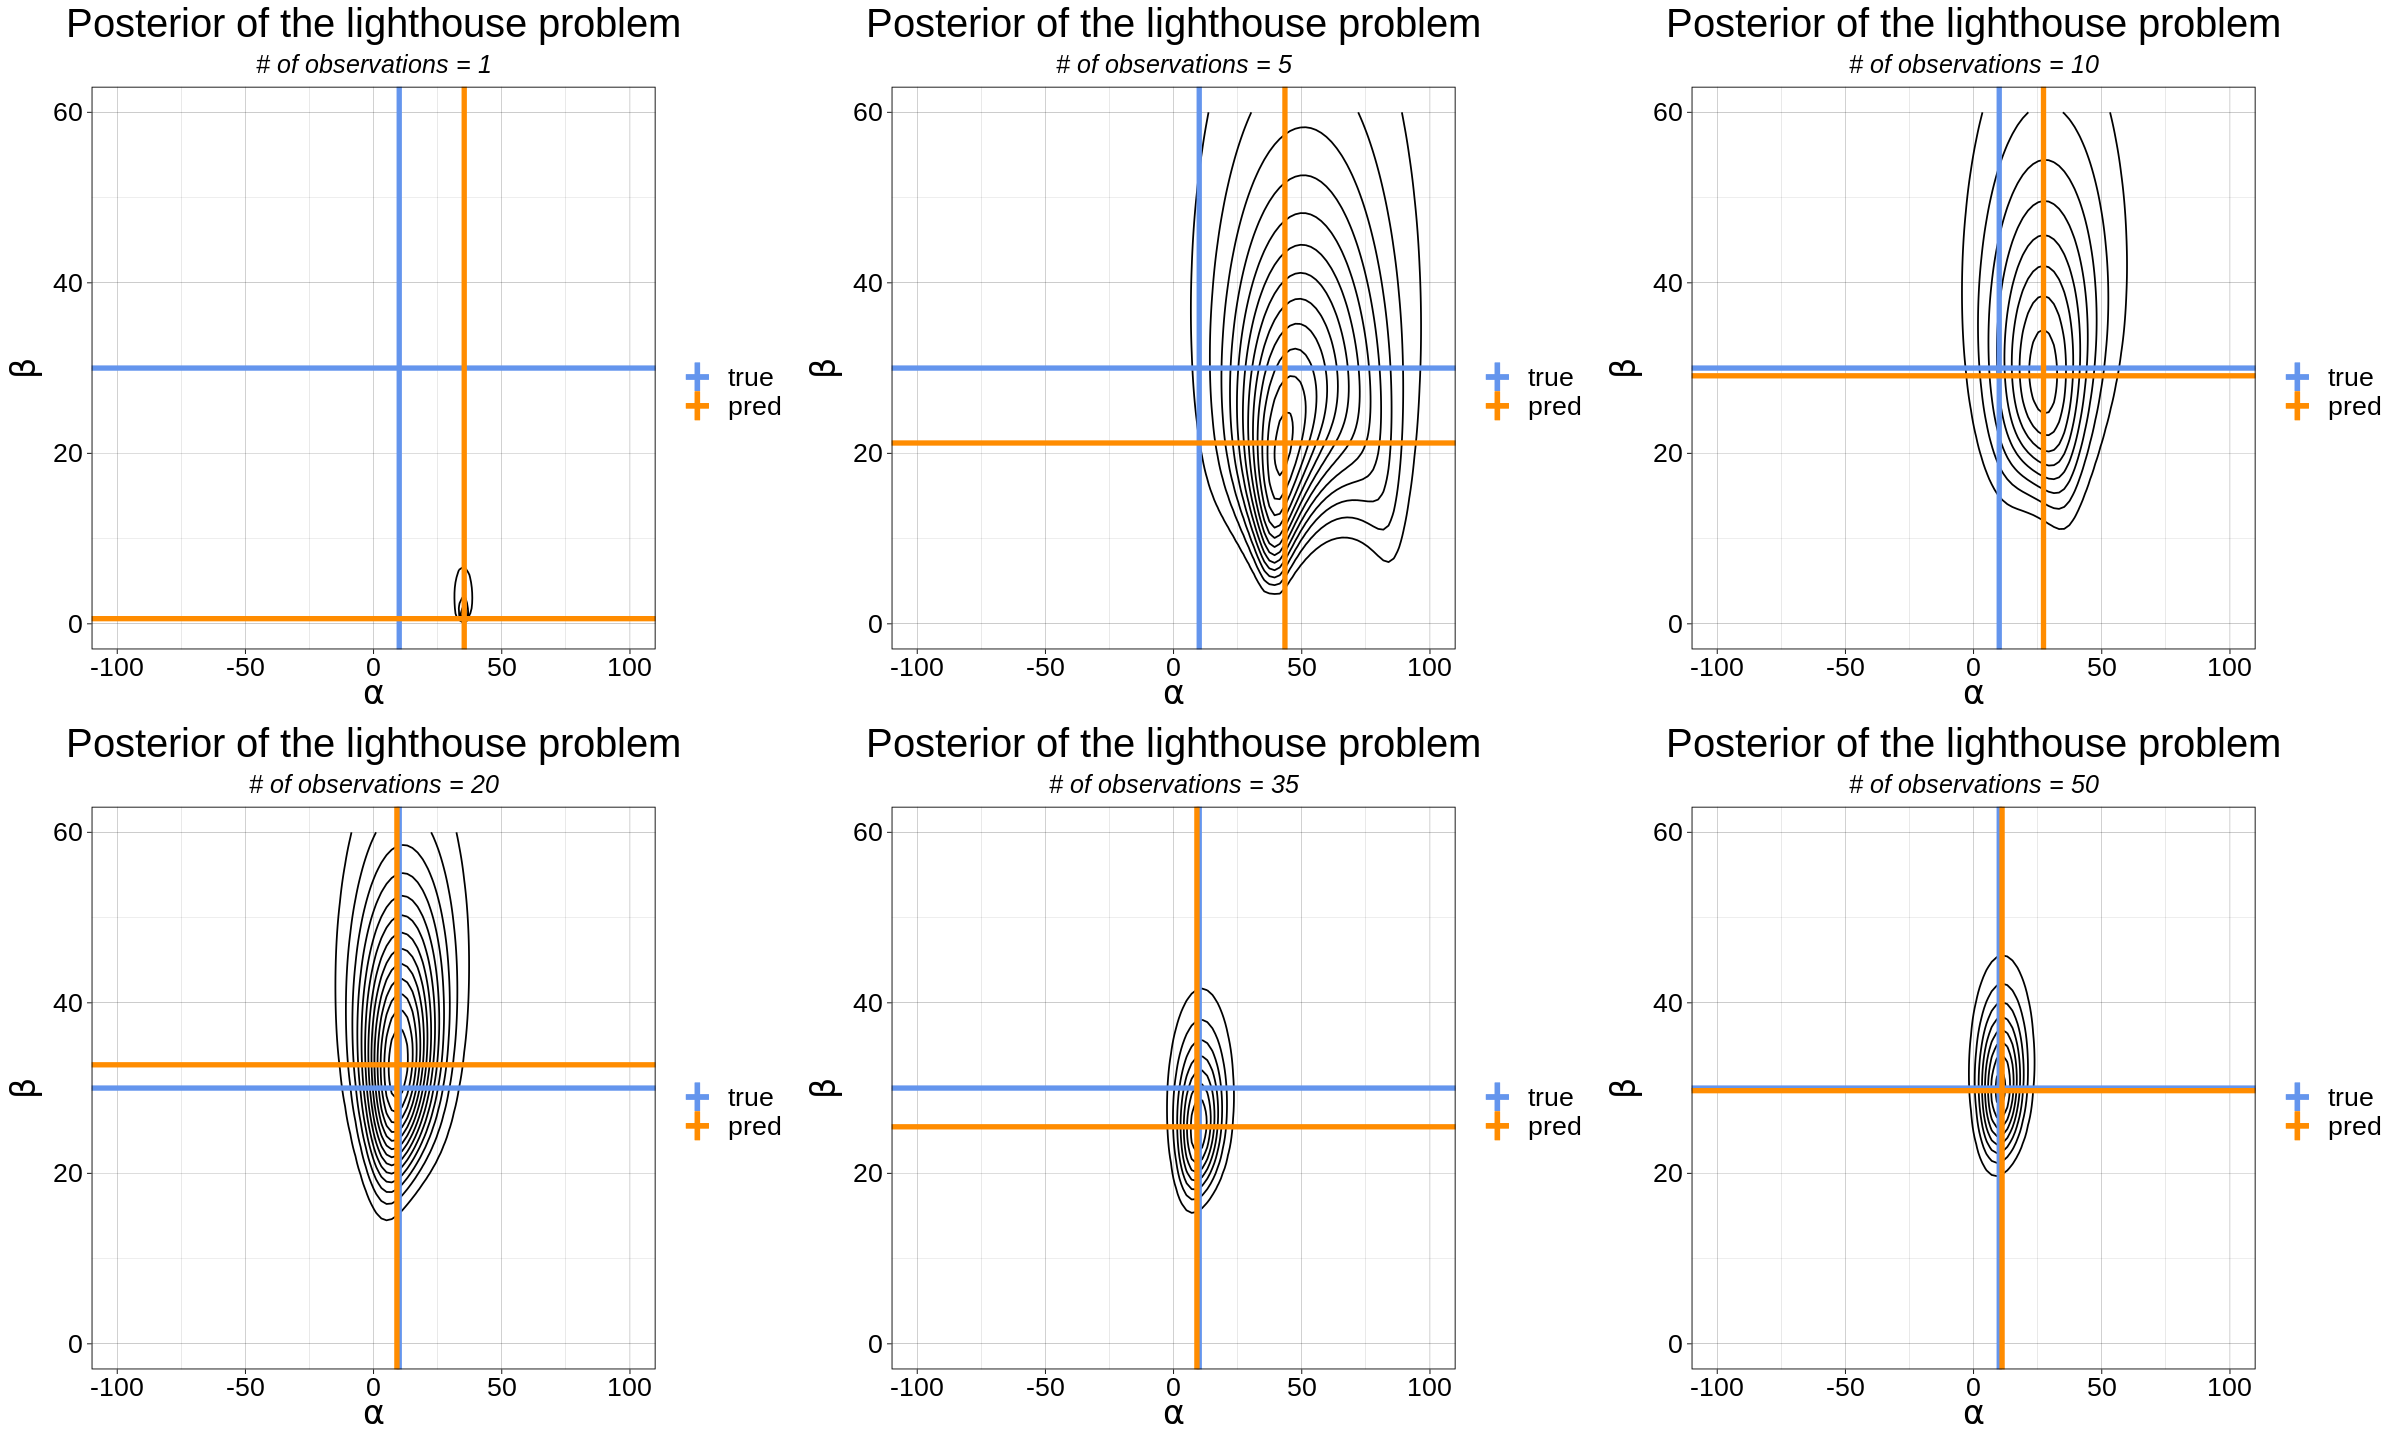

In [73]:
a_true = 10
b_true = 30

gen_data = function(n_obs, a_true, b_true){
    observations = runif(n_obs, -pi/2, pi/2)
    return(a_true+b_true*tan(observations))
}

a_min  = -100
a_max  = 100
b_min  = 0
b_max  = 60

n_points   = 100
area_unit = (a_max-a_min)*(b_max-b_min)/(n_points^2)
alpha_list = seq(a_min, a_max, length.out=n_points)
beta_list  = seq(b_min, b_max, length.out=n_points)

cols = c("true"="cornflowerblue", "pred"="darkorange")

log_like = function(observations, alpha, beta){
    return(sum(to_vec(for(x in observations) log(beta/((beta^2+(x-alpha)^2)*pi)))))
}

sample_size = c(1, 5, 10, 20, 35, 50)
plots = list()
options(repr.plot.width=20, repr.plot.height=12) 

for (k in 1:length(sample_size)){

    size = sample_size[k]

    # create empty matrix
    log_post_m = matrix(data=NA, nrow=n_points, ncol=n_points)
    # generate data
    set.seed(12345)
    observations = gen_data(size, a_true, b_true)

    # compute log posterior (unnormalized) over the parameters grid
    for(i in 1:n_points){
        for(j in 1:n_points){
            log_post_m[i, j] = log_like(observations, alpha_list[i], beta_list[j])
        }
    }

    # normalize posterior
    post_m = exp(log_post_m)/(area_unit*sum(exp(log_post_m)))

    # flatten matrix
    post3d = melt(post_m)
    colnames(post3d) = c('alpha', 'beta', 'post')

    # extract all parameters combinations
    alpha_list2d = to_vec(for(i in post3d$alpha) alpha_list[i])
    beta_list2d  = to_vec(for(i in post3d$beta) beta_list[i])

    p = ggplot() +
        theme_linedraw() + 
        stat_contour(aes(x=alpha_list2d, y=beta_list2d, z=post3d$post), color="black") +
        geom_vline(aes(xintercept=a_true, color="true"), lwd=1.5) +
        geom_hline(aes(yintercept=b_true, color="true"), lwd=1.5) +
        geom_vline(aes(xintercept=alpha_list[post3d$alpha[which.max(post3d$post)]], color="pred"), lwd=1.5) +
        geom_hline(aes(yintercept=beta_list[post3d$beta[which.max(post3d$post)]], color="pred"), lwd=1.5) +
        xlim(c(a_min, a_max)) +
        ylim(c(b_min, b_max)) +
        scale_color_manual(name="",
                        values=cols) +
        theme(text = element_text(size=20)) +
        ggtitle("Posterior of the lighthouse problem") +
        labs(subtitle=paste("# of observations =", size)) +
        theme(plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
        ylab(expression(beta)) +
        xlab(expression(alpha))
    
    plots[[k]] = ggplotGrob(p)
}

grid.arrange(grobs=plots, ncol=3)

It is clear how at increasing number of observations the posterior take the shape of a 2d gaussian that becomes narrower as the data size increases.

## Exercise 3

Given the Signal over Background example discussed last week, analyze and discuss the following cases:

a) vary the sampling resolution of used to generate the data, keeping the same sampling range `xdat = seq(from=-7*w, to=7*w, by=r*w)`, change the resolution `r = {0.1, 0.25, 1, 2, 3}`, check the effect on the results


b) change the ratio $A/B$ used to simulate the data (keeping both positive in accordance with the prior), check the effect on the results

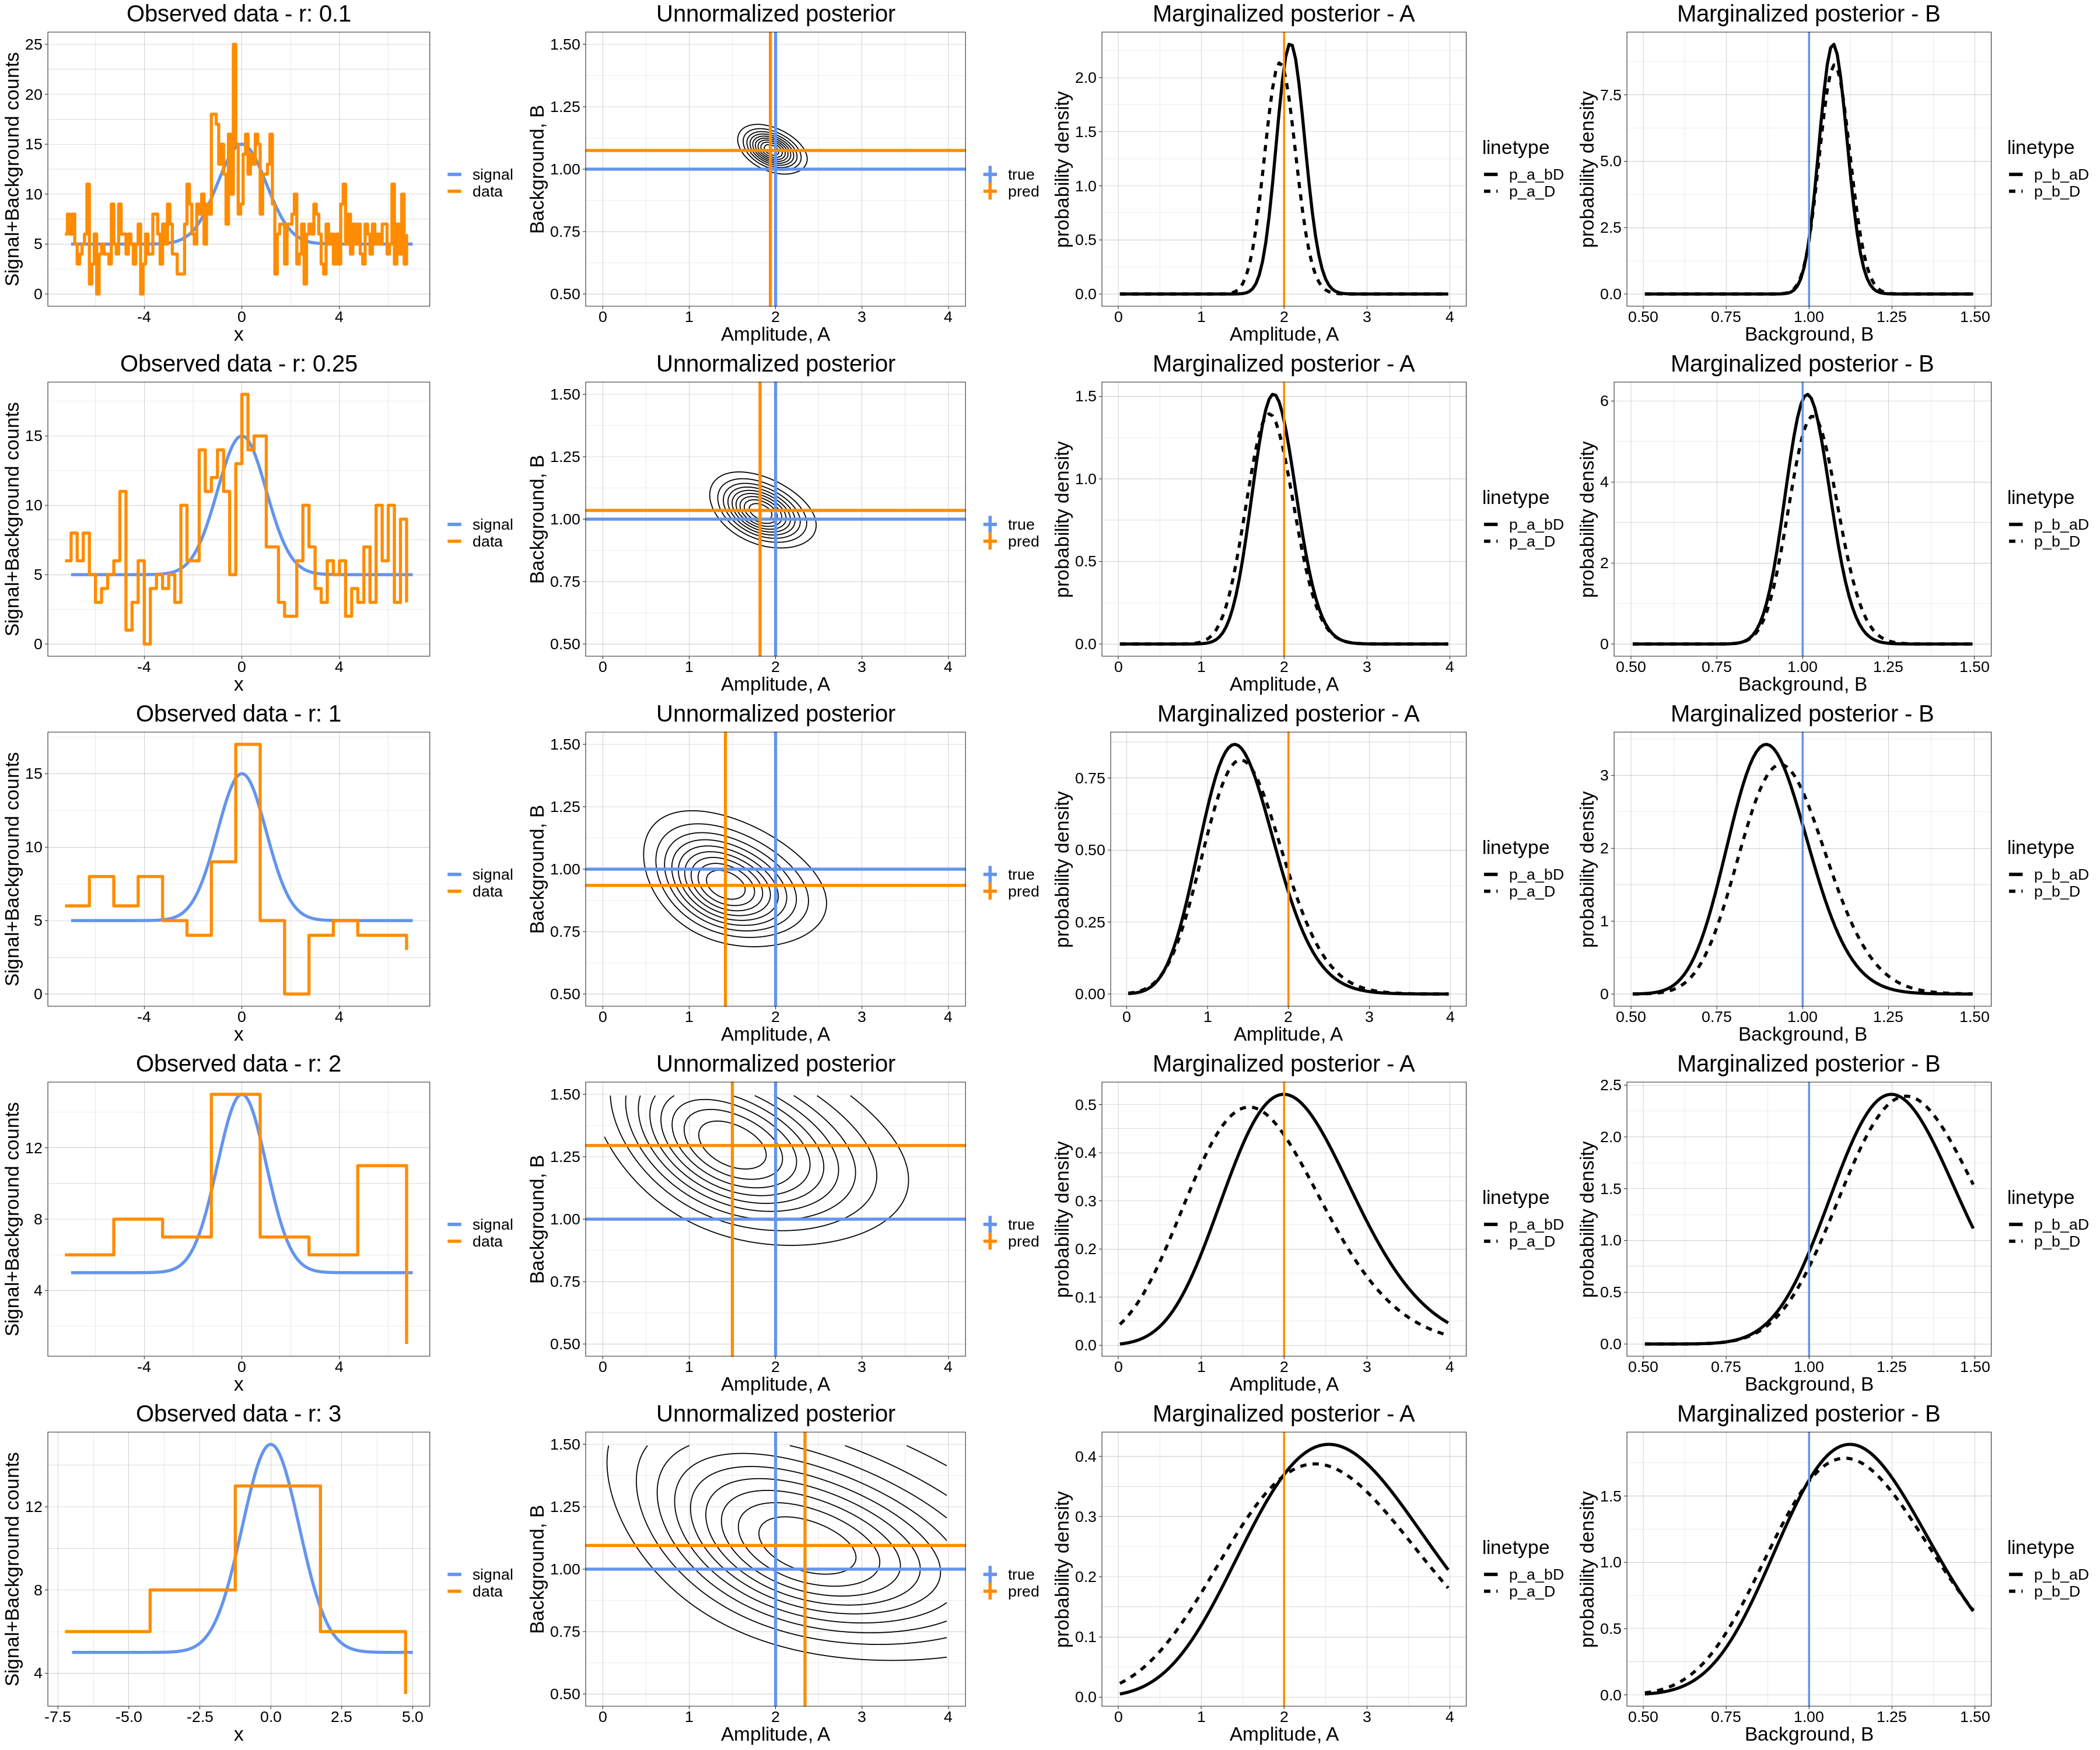

In [182]:
# Generative model
signal = function(x, a, b, x0, w, t) {
    return(t*(a*exp(-(x-x0)^2/(2*w^2))+b))
}

# Define model parameters
x0 = 0 # Signal peak
w = 1 # Signal width
a_true = 2 # Signal amplitude
b_true = 1 # Background amplitude
Delta_t = 5 # Exposure time

# - Sampling grid for computing posterior
a_max = 4
a_min = 0
b_max = 1.5
b_min = 0.5
Nsamp = 100
uniGrid = seq(from=1/(2*Nsamp),
to=1-1/(2*Nsamp), by=1/Nsamp)
delta_a = (a_max-a_min)/Nsamp
delta_b = (b_max-b_min)/Nsamp
a = a_min + (a_max-a_min)*uniGrid
b = b_min + (b_max-b_min)*uniGrid

# Log posterior
log.post = function(d, x, a, b, x0, w, t) {
    if(a<0 || b <0) {return(-Inf)} # the effect of the prior
    return(sum(dpois(d, lambda=signal(x, a, b, x0, w, t), log=TRUE)))
}

resolution = c(0.1, 0.25, 1, 2, 3)
options(repr.plot.width=30, repr.plot.height=25) 
plots = list()
plot_counter = 1

mean_a = c()
mean_b = c()
sd_a = c()
sd_b = c()

for(i in 1:length(resolution)){
    r = resolution[i]

    # Generate the observed data
    set.seed(12345)
    xdat = seq(from=-7*w, to=7*w, by=r*w)
    s_true = signal(xdat, a_true,
    b_true, x0, w, Delta_t)
    ddat = rpois(length(s_true), s_true)
    xplot = seq(from=min(xdat), to=max(xdat), by=0.05*w)
    splot = signal(xplot, a_true,
    b_true, x0, w, Delta_t)
    xdat.off = xdat-0.25

    cols = c("signal"="cornflowerblue", "data"="darkorange")
    data_plot = ggplot() +
          theme_linedraw() +                                            
          geom_line( aes(x=xplot, y=splot, color="signal"),  lwd=1.5) +  
          geom_step( aes(x=xdat.off, y=ddat, color="data"), lwd=1.5, stat="identity") +                                                        
          theme(text = element_text(size=20)) +
          ggtitle(paste("Observed data - r:", r*w)) +
          theme(plot.title = element_text(hjust = 0.5))  +
          ylab("Signal+Background counts") +
          xlab("x") +
          scale_color_manual(name="", values=cols)
          
    plots[[plot_counter]] = ggplotGrob(data_plot)
    plot_counter = plot_counter + 1

    # Compute log unnormalized posterior , z = ln P^*(a,b|D), on a regular grid
    z = matrix(data=NA, nrow=length(a), ncol=length(b))
    for(j in 1:length(a)) {
        for(k in 1:length(b)) {
            z[j,k] = log.post(ddat, xdat, a[j], b[k], x0, w, Delta_t)
        }
    }
    z = z - max(z) # set maximum to zero

    # flatten matrix
    post3d = melt(exp(z))
    colnames(post3d) = c('a', 'b', 'post')

    # extract all parameters combinations
    a_2d = to_vec(for(i in post3d$a) a[i])
    b_2d  = to_vec(for(i in post3d$b) b[i])

    cols = c("true"="cornflowerblue", "pred"="darkorange")
    post_plot = ggplot() +
        theme_linedraw() + 
        stat_contour(aes(x=a_2d, y=b_2d, z=post3d$post), color="black") +
        geom_vline(aes(xintercept=a_true, color="true"), lwd=1.5) +
        geom_hline(aes(yintercept=b_true, color="true"), lwd=1.5) +
        geom_vline(aes(xintercept=a[post3d$a[which.max(post3d$post)]], color="pred"), lwd=1.5) +
        geom_hline(aes(yintercept=b[post3d$b[which.max(post3d$post)]], color="pred"), lwd=1.5) +
        theme(text = element_text(size=20)) +
        ggtitle("Unnormalized posterior") +
        theme(plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
        ylab("Background, B") +
        xlab("Amplitude, A") +
        xlim(c(a_min, a_max)) +
        ylim(c(b_min, b_max)) +
        scale_color_manual(name="", values=cols)

    plots[[plot_counter]] = ggplotGrob(post_plot)
    plot_counter = plot_counter + 1

    # Compute normalized marginalized posteriors , P(a|D) and P(b|D)
    # by summing over other parameter. Normalize by gridding.
    p_a_D = apply(exp(z), 1, sum)
    p_a_D = p_a_D/(delta_a*sum(p_a_D))
    p_b_D = apply(exp(z), 2, sum)
    p_b_D = p_b_D/(delta_b*sum(p_b_D))

    # Compute normalized conditional posteriors , P(a|b,D) and P(b|a,D)
    # using true values of conditioned parameters. Vectorize(func , par)
    # makes a vectorized function out of func in the parameter par.
    p_a_bD = exp(Vectorize(log.post, "a")(ddat, xdat, a, b_true, x0, w, Delta_t))
    p_a_bD = p_a_bD/(delta_a*sum(p_a_bD))
    p_b_aD = exp(Vectorize(log.post, "b")(ddat, xdat, a_true, b, x0, w, Delta_t))
    p_b_aD = p_b_aD/(delta_b*sum(p_b_aD))

    ltype = c("p_a_D"="smooth", "p_a_bD"="dashed")
    mar_post_a_plot = ggplot() +
        theme_linedraw() + 
        geom_line(aes(x=a, y=p_a_D, linetype="p_a_D"), lwd=1.5) +
        geom_line(aes(x=a, y=p_a_bD, linetype="p_a_bD"), lwd=1.5) +
        geom_vline(aes(xintercept=a_true), color="darkorange", lwd=1) +
        theme(text = element_text(size=20)) +
        ggtitle("Marginalized posterior - A") +
        theme(plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
        ylab("probability density") +
        xlab("Amplitude, A") +
        xlim(c(a_min, a_max))

    plots[[plot_counter]] = ggplotGrob(mar_post_a_plot)
    plot_counter = plot_counter + 1

    ltype = c("p_b_D"="smooth", "p_b_aD"="dashed")
    mar_post_b_plot = ggplot() +
        theme_linedraw() + 
        geom_line(aes(x=b, y=p_b_D, linetype="p_b_D"), lwd=1.5) +
        geom_line(aes(x=b, y=p_b_aD, linetype="p_b_aD"), lwd=1.5) +
        geom_vline(aes(xintercept=b_true), color="cornflowerblue", lwd=1) +
        theme(text = element_text(size=20)) +
        ggtitle("Marginalized posterior - B") +
        theme(plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
        ylab("probability density") +
        xlab("Background, B") +
        xlim(c(b_min, b_max))

    plots[[plot_counter]] = ggplotGrob(mar_post_b_plot)
    plot_counter = plot_counter + 1

    # Compute mean , standard deviation , covariance , correlation , of A and B
    mean_a = c(mean_a, delta_a * sum(a * p_a_D))
    mean_b = c(mean_b, delta_b * sum(b * p_b_D))
    sd_a = c(sd_a, sqrt( delta_a * sum((a-mean_a[length(mean_a)])^2 * p_a_D) ))
    sd_b = c(sd_b, sqrt( delta_b * sum((b-mean_b[length(mean_b)])^2 * p_b_D) ))
    
}

grid.arrange(grobs=plots, ncol=4)

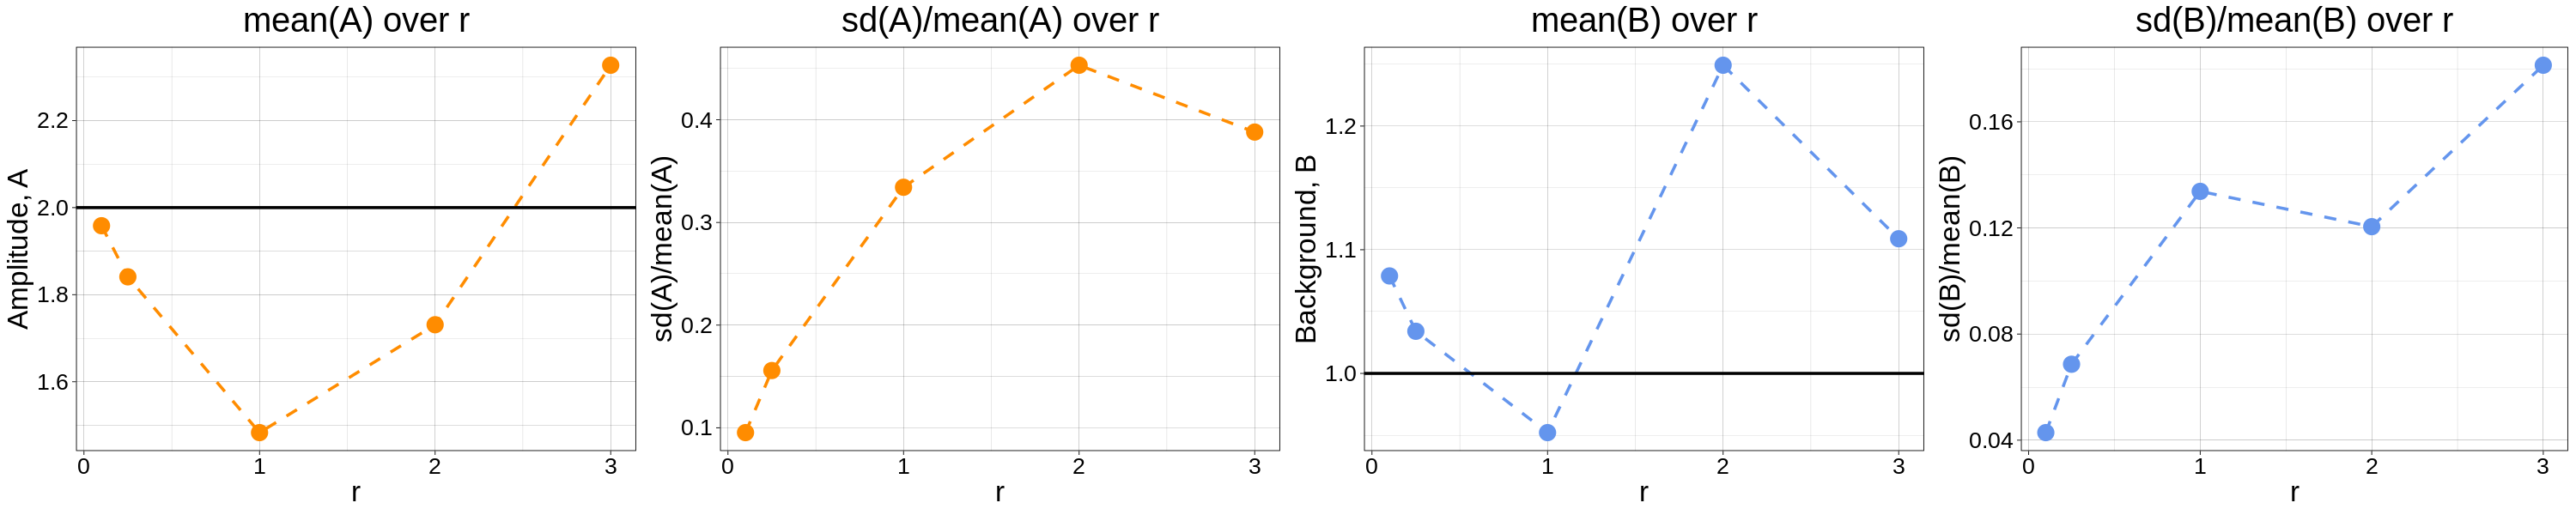

In [189]:
options(repr.plot.width=25, repr.plot.height=5) 
p_A = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=resolution, y=mean_a), color="darkorange", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=resolution, y=mean_a), color="darkorange", size = 5) +    
     geom_hline(aes(yintercept=a_true), lwd=1, color="black") +                                                         
     theme(text = element_text(size=20)) +
     ggtitle("mean(A) over r") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("Amplitude, A") +
     xlab("r")

p_sdA_A = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=resolution, y=sd_a/mean_a), color="darkorange", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=resolution, y=sd_a/mean_a), color="darkorange", size = 5) +                                                           
     theme(text = element_text(size=20)) +
     ggtitle("sd(A)/mean(A) over r") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("sd(A)/mean(A)") +
     xlab("r")

p_B = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=resolution, y=mean_b), color="cornflowerblue", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=resolution, y=mean_b), color="cornflowerblue", size = 5) +    
     geom_hline(aes(yintercept=b_true), lwd=1, color="black") +                                                         
     theme(text = element_text(size=20)) +
     ggtitle("mean(B) over r") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("Background, B") +
     xlab("r")

p_sdB_B = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=resolution, y=sd_b/mean_b), color="cornflowerblue", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=resolution, y=sd_b/mean_b), color="cornflowerblue", size = 5) +                                                           
     theme(text = element_text(size=20)) +
     ggtitle("sd(B)/mean(B) over r") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("sd(B)/mean(B)") +
     xlab("r")

grid.arrange(p_A, p_sdA_A, p_B, p_sdB_B, ncol=4)

Defining resolution in units of signal width as $1/r$ we can observe how at higher resolutions (smaller $r$ values) we get better results both in terms of distance from the true value and parameter relative error.

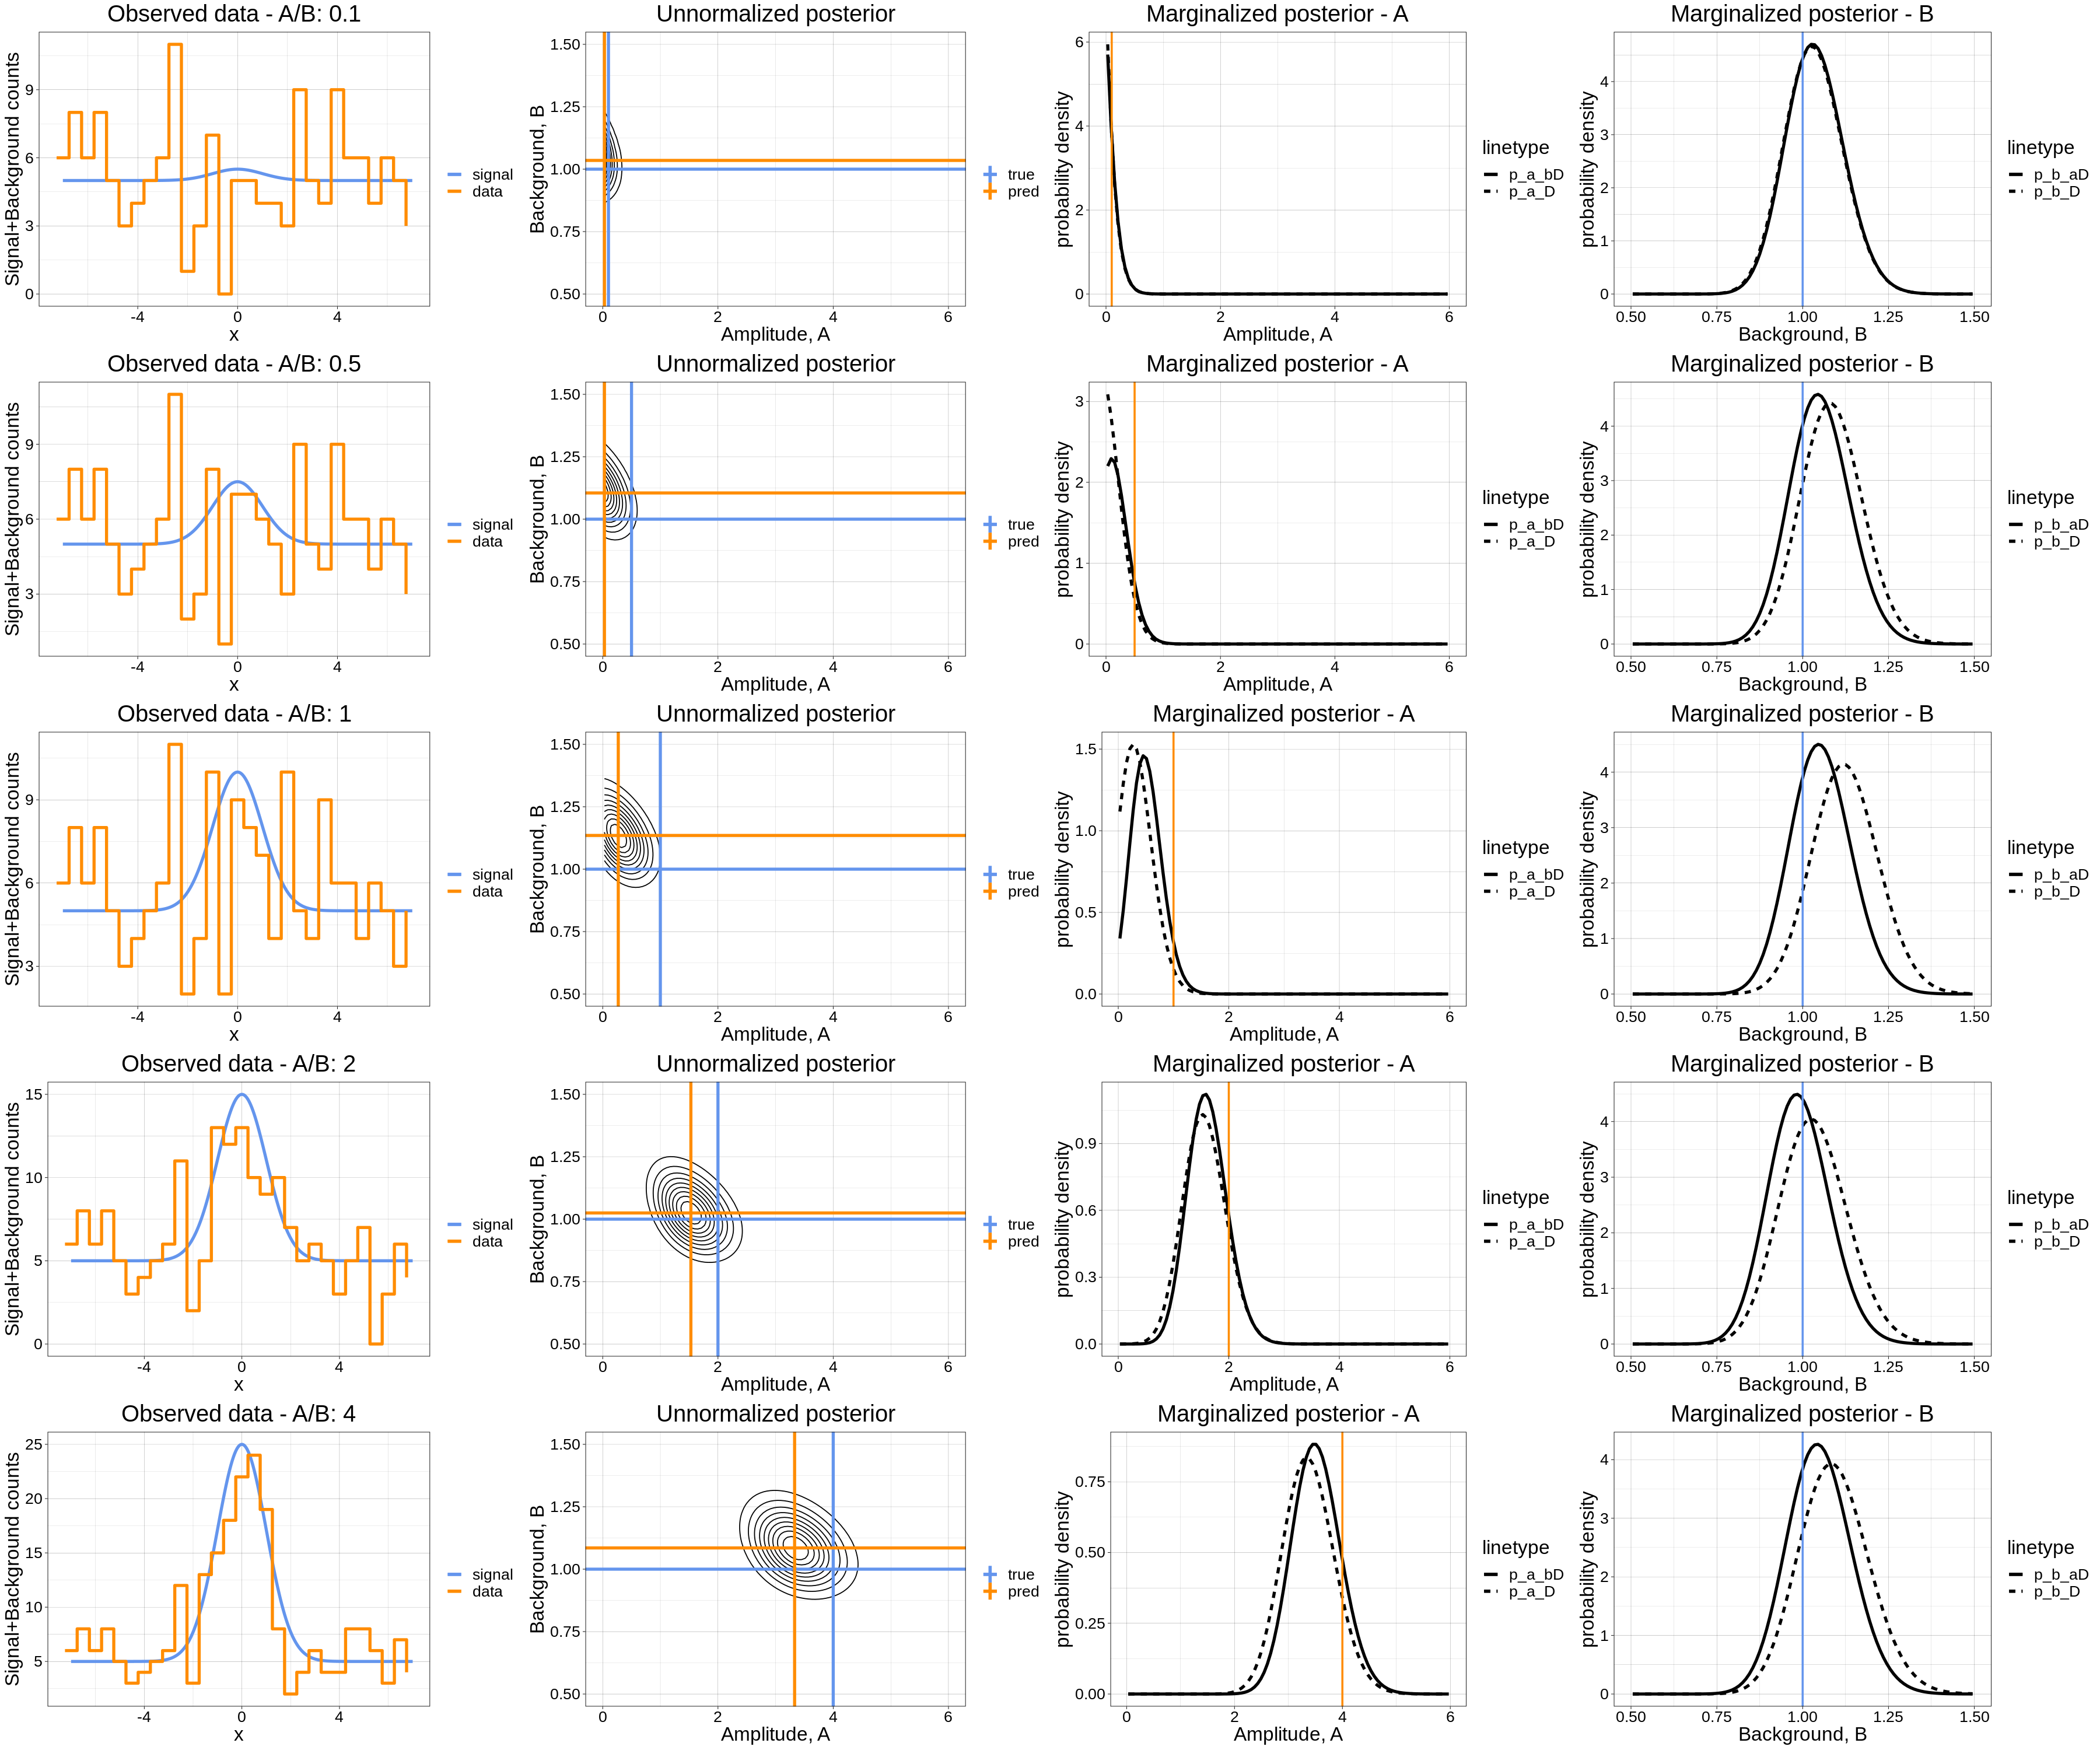

In [190]:
a_true_list = c(0.1, 0.5, 1, 2, 4) # Signal amplitude
b_true = 1 # Background amplitude
r = 0.5 # 1/resolution in w units

# - Sampling grid for computing posterior
a_max = 6
a_min = 0
b_max = 1.5
b_min = 0.5
Nsamp = 100
uniGrid = seq(from=1/(2*Nsamp),
to=1-1/(2*Nsamp), by=1/Nsamp)
delta_a = (a_max-a_min)/Nsamp
delta_b = (b_max-b_min)/Nsamp
a = a_min + (a_max-a_min)*uniGrid
b = b_min + (b_max-b_min)*uniGrid

options(repr.plot.width=30, repr.plot.height=25) 
plots = list()
plot_counter = 1

mean_a = c()
mean_b = c()
sd_a = c()
sd_b = c()

for(i in 1:length(a_true_list)){
    a_true = a_true_list[i]

    # Generate the observed data
    set.seed(12345)
    xdat = seq(from=-7*w, to=7*w, by=r*w)
    s_true = signal(xdat, a_true, b_true, x0, w, Delta_t)
    ddat = rpois(length(s_true), s_true)
    xplot = seq(from=min(xdat), to=max(xdat), by=0.05*w)
    splot = signal(xplot, a_true, b_true, x0, w, Delta_t)
    xdat.off = xdat-0.25

    cols = c("signal"="cornflowerblue", "data"="darkorange")
    data_plot = ggplot() +
          theme_linedraw() +                                            
          geom_line( aes(x=xplot, y=splot, color="signal"),  lwd=1.5) +  
          geom_step( aes(x=xdat.off, y=ddat, color="data"), lwd=1.5, stat="identity") +                                                        
          theme(text = element_text(size=20)) +
          ggtitle(paste("Observed data - A/B:", a_true)) +
          theme(plot.title = element_text(hjust = 0.5))  +
          ylab("Signal+Background counts") +
          xlab("x") +
          scale_color_manual(name="", values=cols)
          
    plots[[plot_counter]] = ggplotGrob(data_plot)
    plot_counter = plot_counter + 1

    # Compute log unnormalized posterior , z = ln P^*(a,b|D), on a regular grid
    z = matrix(data=NA, nrow=length(a), ncol=length(b))
    for(j in 1:length(a)) {
        for(k in 1:length(b)) {
            z[j,k] = log.post(ddat, xdat, a[j], b[k], x0, w, Delta_t)
        }
    }
    z = z - max(z) # set maximum to zero

    # flatten matrix
    post3d = melt(exp(z))
    colnames(post3d) = c('a', 'b', 'post')

    # extract all parameters combinations
    a_2d = to_vec(for(i in post3d$a) a[i])
    b_2d  = to_vec(for(i in post3d$b) b[i])

    cols = c("true"="cornflowerblue", "pred"="darkorange")
    post_plot = ggplot() +
        theme_linedraw() + 
        stat_contour(aes(x=a_2d, y=b_2d, z=post3d$post), color="black") +
        geom_vline(aes(xintercept=a_true, color="true"), lwd=1.5) +
        geom_hline(aes(yintercept=b_true, color="true"), lwd=1.5) +
        geom_vline(aes(xintercept=a[post3d$a[which.max(post3d$post)]], color="pred"), lwd=1.5) +
        geom_hline(aes(yintercept=b[post3d$b[which.max(post3d$post)]], color="pred"), lwd=1.5) +
        theme(text = element_text(size=20)) +
        ggtitle("Unnormalized posterior") +
        theme(plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
        ylab("Background, B") +
        xlab("Amplitude, A") +
        xlim(c(a_min, a_max)) +
        ylim(c(b_min, b_max)) +
        scale_color_manual(name="", values=cols)

    plots[[plot_counter]] = ggplotGrob(post_plot)
    plot_counter = plot_counter + 1

    # Compute normalized marginalized posteriors , P(a|D) and P(b|D)
    # by summing over other parameter. Normalize by gridding.
    p_a_D = apply(exp(z), 1, sum)
    p_a_D = p_a_D/(delta_a*sum(p_a_D))
    p_b_D = apply(exp(z), 2, sum)
    p_b_D = p_b_D/(delta_b*sum(p_b_D))

    # Compute normalized conditional posteriors , P(a|b,D) and P(b|a,D)
    # using true values of conditioned parameters. Vectorize(func , par)
    # makes a vectorized function out of func in the parameter par.
    p_a_bD = exp(Vectorize(log.post, "a")(ddat, xdat, a, b_true, x0, w, Delta_t))
    p_a_bD = p_a_bD/(delta_a*sum(p_a_bD))
    p_b_aD = exp(Vectorize(log.post, "b")(ddat, xdat, a_true, b, x0, w, Delta_t))
    p_b_aD = p_b_aD/(delta_b*sum(p_b_aD))

    ltype = c("p_a_D"="smooth", "p_a_bD"="dashed")
    mar_post_a_plot = ggplot() +
        theme_linedraw() + 
        geom_line(aes(x=a, y=p_a_D, linetype="p_a_D"), lwd=1.5) +
        geom_line(aes(x=a, y=p_a_bD, linetype="p_a_bD"), lwd=1.5) +
        geom_vline(aes(xintercept=a_true), color="darkorange", lwd=1) +
        theme(text = element_text(size=20)) +
        ggtitle("Marginalized posterior - A") +
        theme(plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
        ylab("probability density") +
        xlab("Amplitude, A") +
        xlim(c(a_min, a_max))

    plots[[plot_counter]] = ggplotGrob(mar_post_a_plot)
    plot_counter = plot_counter + 1

    ltype = c("p_b_D"="smooth", "p_b_aD"="dashed")
    mar_post_b_plot = ggplot() +
        theme_linedraw() + 
        geom_line(aes(x=b, y=p_b_D, linetype="p_b_D"), lwd=1.5) +
        geom_line(aes(x=b, y=p_b_aD, linetype="p_b_aD"), lwd=1.5) +
        geom_vline(aes(xintercept=b_true), color="cornflowerblue", lwd=1) +
        theme(text = element_text(size=20)) +
        ggtitle("Marginalized posterior - B") +
        theme(plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(size=15, hjust=0.5, face="italic"))  +
        ylab("probability density") +
        xlab("Background, B") +
        xlim(c(b_min, b_max))

    plots[[plot_counter]] = ggplotGrob(mar_post_b_plot)
    plot_counter = plot_counter + 1

    # Compute mean , standard deviation , covariance , correlation , of A and B
    mean_a = c(mean_a, delta_a * sum(a * p_a_D))
    mean_b = c(mean_b, delta_b * sum(b * p_b_D))
    sd_a = c(sd_a, sqrt( delta_a * sum((a-mean_a[length(mean_a)])^2 * p_a_D) ))
    sd_b = c(sd_b, sqrt( delta_b * sum((b-mean_b[length(mean_b)])^2 * p_b_D) ))
    
}

grid.arrange(grobs=plots, ncol=4)

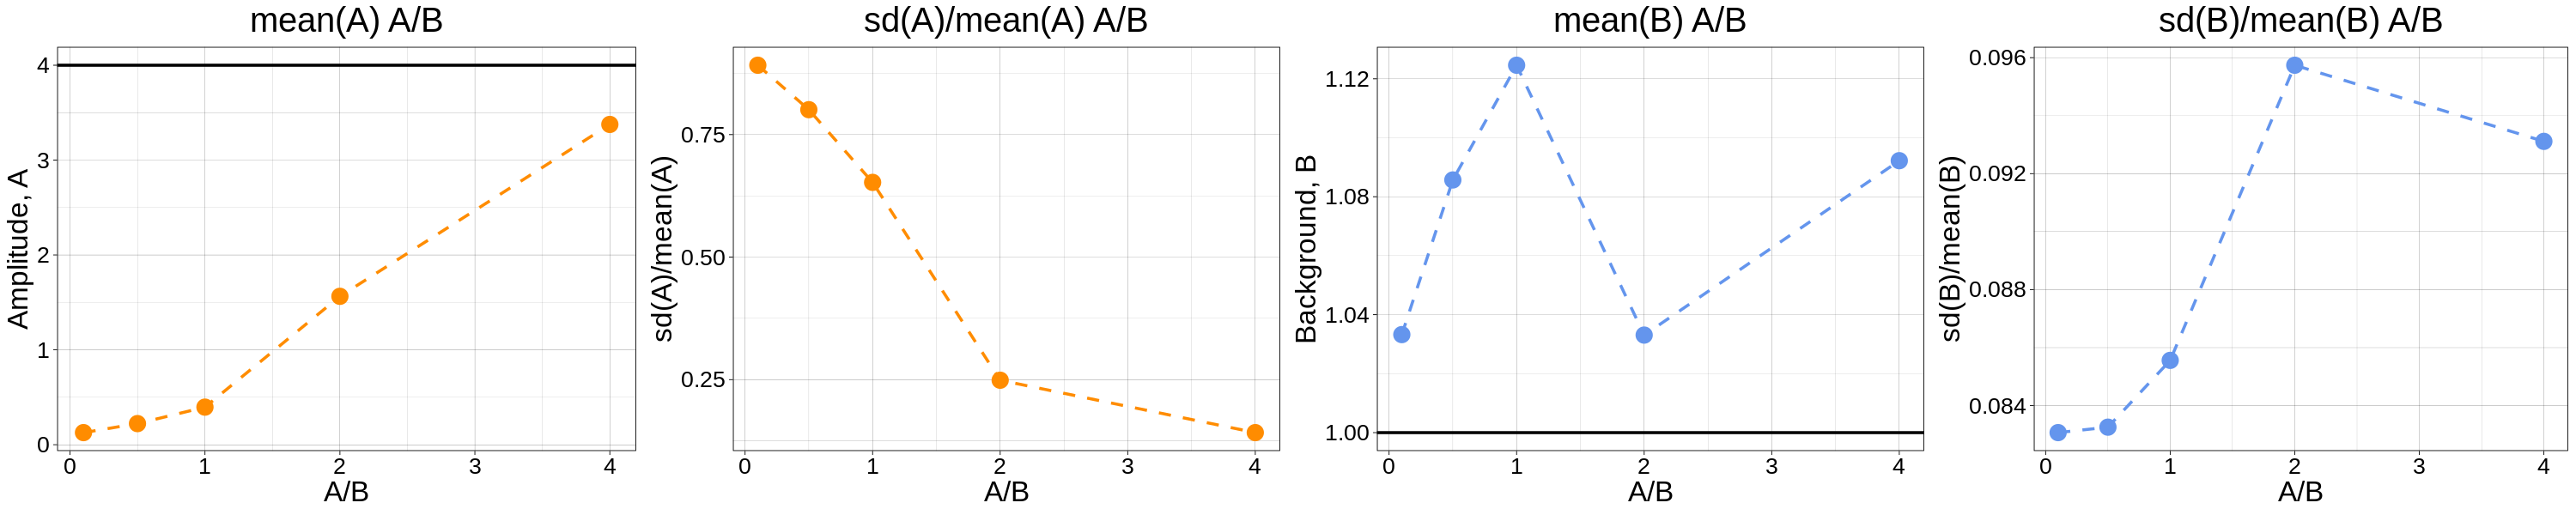

In [192]:
options(repr.plot.width=25, repr.plot.height=5) 
p_A = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=a_true_list, y=mean_a), color="darkorange", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=a_true_list, y=mean_a), color="darkorange", size = 5) +    
     geom_hline(aes(yintercept=a_true), lwd=1, color="black") +                                                         
     theme(text = element_text(size=20)) +
     ggtitle("mean(A) A/B") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("Amplitude, A") +
     xlab("A/B")

p_sdA_A = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=a_true_list, y=sd_a/mean_a), color="darkorange", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=a_true_list, y=sd_a/mean_a), color="darkorange", size = 5) +                                                           
     theme(text = element_text(size=20)) +
     ggtitle("sd(A)/mean(A) A/B") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("sd(A)/mean(A)") +
     xlab("A/B")

p_B = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=a_true_list, y=mean_b), color="cornflowerblue", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=a_true_list, y=mean_b), color="cornflowerblue", size = 5) +    
     geom_hline(aes(yintercept=b_true), lwd=1, color="black") +                                                         
     theme(text = element_text(size=20)) +
     ggtitle("mean(B) A/B") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("Background, B") +
     xlab("A/B")

p_sdB_B = ggplot() +   
     theme_linedraw() +                                            
     geom_line(aes(x=a_true_list, y=sd_b/mean_b), color="cornflowerblue", lwd = 1, linetype="dashed") + 
     geom_point(aes(x=a_true_list, y=sd_b/mean_b), color="cornflowerblue", size = 5) +                                                           
     theme(text = element_text(size=20)) +
     ggtitle("sd(B)/mean(B) A/B") +
     theme(plot.title = element_text(hjust = 0.5))  +
     ylab("sd(B)/mean(B)") +
     xlab("A/B")

grid.arrange(p_A, p_sdA_A, p_B, p_sdB_B, ncol=4)

Focusing on $A$ parameter we observe a clear trend, higher the amplitude/background ratio better is the final estimated parameter, both in terms of distance from the true value and relative error. The estimation of the $B$ parameter instead is not influenced too much by the changing ratio, this is probabily due to the fact that we changed only $A$ to change the $A/B$ ratio, I expect that if I change both $A$ and $B$ I would observe a similar behaviour as the $A$ parameter also for the $B$ one.